### Example 1 - Map of chlorophyll content in the North West Atlantic (Poseidon version)

This example shows how to read and manipulate Argo profiles data stored in parquet format in CrocoLake.

The data are stored across multiple files: we will load into memory only what we need by applying some filters, and we will create a map showing the chlorophyll content in the North West Atlantic.

##### Note on the data location
You need to point the code to the location of CrocoLake in your machine.

#### Getting started

We start by importing the necessary modules.

In [1]:
# modules to handle the data
import crocolakeloader.params as params
from crocolakeloader.loader import Loader
from datetime import datetime, timedelta

# modules for visualizations
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

We now want to set up our filter to read only the data from the NWA (i.e. latitude between 34$^\circ$ and 80$^\circ$, longitude between -50$^\circ$ and -78$^\circ$). We also assume we are only interested in the data closer to the surface (pressure below 50 dbar).

The loader allows us to specify the type of data (physical or bgc), the database (here, 'ARGO') and path to our CrocoLake mirror. We can then pass a filter to select what rows to read based on variables' values.

The geographical coordinates are stored in the variables 'LATITUDE'and 'LONGITUDE'. We then generate the filter, with its syntax being: `[[(column, op, val), …],…]` where `column` is the variable name, and `val` is the value to for the operator `op`, which accepts `[==, =, >, >=, <, <=, !=, in, not in]`,

In [10]:
%%time
# Setting up loader
db_type="BGC"
ref_var = 'CHLA'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES","JULD","TOT_ALKALINITY","BBP470"]

crocolake = Loader(
    selected_variables=cols,
    db_type=db_type,
    db_list=["ARGO","GLODAP"],
    db_rootpath="../CrocoLake/CrocoLake"+db_type
)

# Defining filters
reference_time = datetime.utcnow() - timedelta(days=90)

filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">",reference_time),
                           ("PRES",">=",0),("PRES","<=",50),
                           (ref_var,">=",-1e30),(ref_var,"<=",+1e30)]

crocolake.set_filters(filter_coords_time_pres)

ddf = crocolake.get_dataframe()

Reading data from ['ARGO', 'GLODAP'] .
Reading BGC parameters.
Looking for data in ../CrocoLake/CrocoLakeBGC
Searching for database ARGO in ../CrocoLake/CrocoLakeBGC/*ARGO*.
Found ['../CrocoLake/CrocoLakeBGC/1002_BGC_ARGO-QC-DEV_2025-02-22']
Searching for database GLODAP in ../CrocoLake/CrocoLakeBGC/*GLODAP*.
Found ['../CrocoLake/CrocoLakeBGC/1101_BGC_GLODAP_2024-12-11']
Reading databases from the following paths:
{'ARGO': '../CrocoLake/CrocoLakeBGC/1002_BGC_ARGO-QC-DEV_2025-02-22', 'GLODAP': '../CrocoLake/CrocoLakeBGC/1101_BGC_GLODAP_2024-12-11'}
Reading columns ['CHLA', 'LATITUDE', 'LONGITUDE', 'PRES', 'JULD', 'BBP470'] from db ARGO.
Adding empty column TOT_ALKALINITY to db ARGO
Reading columns ['CHLA', 'LATITUDE', 'LONGITUDE', 'PRES', 'JULD', 'TOT_ALKALINITY'] from db GLODAP.
Adding empty column BBP470 to db GLODAP
CPU times: user 63.8 ms, sys: 28.7 ms, total: 92.6 ms
Wall time: 120 ms


Note that 

In [11]:
%%time
df = ddf.compute()
df

CPU times: user 5.72 s, sys: 1.49 s, total: 7.21 s
Wall time: 2.35 s


,CHLA,LATITUDE,LONGITUDE,PRES,JULD,TOT_ALKALINITY,BBP470
0,0.107067,35.697398,-61.338297,0.0,2024-12-08 05:24:00,<NA>,<NA>
1,0.108283,35.697398,-61.338297,0.1,2024-12-08 05:24:00,<NA>,<NA>
2,0.1095,35.697398,-61.338297,0.2,2024-12-08 05:24:00,<NA>,<NA>
3,0.11315,35.697398,-61.338297,0.3,2024-12-08 05:24:00,<NA>,<NA>
4,0.106458,35.697398,-61.338297,0.4,2024-12-08 05:24:00,<NA>,<NA>
...,...,...,...,...,...,...,...
76,0.1908,38.295,-59.451,27.01,2025-02-06 19:17:23.002063360,<NA>,<NA>
77,0.2016,38.295,-59.451,32.169998,2025-02-06 19:17:23.002063360,<NA>,<NA>
78,0.1944,38.295,-59.451,37.059998,2025-02-06 19:17:23.002063360,<NA>,<NA>
79,0.1836,38.295,-59.451,42.179996,2025-02-06 19:17:23.002063360,<NA>,<NA>


You can explore the dataframe just by calling it (`df`) as we did above. If you want a list of the variables that are stored, you can use `sorted(df.columns.to_list())`.

#### Timing test

Let's call again the same function, but we time its execution now:

It should have taken a total wall time of 8 to 9 seconds. 

We now want to compare this with Argopy's functionalities. Its data fetcher requires to specificy the depth range, which we then set to between 0 and 10000, i.e. all depths present in the dataset.

NB: the execution should throw an exception (if it doesn't, let me know!). This is likely due to ERDAP's servers timing out after 1 min (as the wall time consistently measures).

We just saw that if we need a large amount of data, our parquet-based mirror of Argo's data is faster.

Now let's narrow the filters in the time and depth -- let's say we we want to select the data for the past three months and measured between 0 and 50 db.

It now took between 5-6 seconds for our Argo mirror, and 2 to 3 seconds using Argo ERDDAP's servers. These can be faster when we need to access a contained amount of data.

#### Map

As in this example we are only interested in the chlorophyll, we can specify it as the only column to import (together with the geographical and temporal coordinates). We do this through the variable `columns` of `read_parquet()`. We also adjust the filter to consider only data labeled with QC=1.

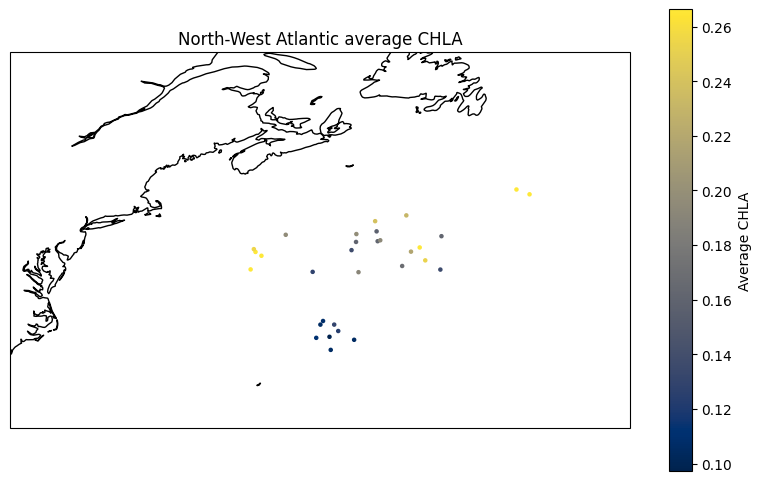

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Convert 'JULD' column to datetime type
# df['JULD'] = pd.to_datetime(df['JULD'])

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED', 'JULD', and 'CHLA_ADJUSTED'
grouped = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES': 'mean',  # Take the mean depth
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = df[ref_var].quantile(q=0.1)
cbar_max = df[ref_var].quantile(q=0.9)
plt.scatter(
    grouped['LONGITUDE'], grouped['LATITUDE'],
    c=grouped[ref_var],
    vmin=cbar_min, vmax=cbar_max, cmap='cividis', s=5,
    transform=ccrs.PlateCarree()
)
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([-78, -45])
plt.ylim([30, 50])
plt.show()

#### Exercise

Try and access some other metadata, for example:
* filtering by different time periods;
* mapping a different parameter;
* restraining the quality of the data further by imposing PRES_ADJUSTED_ERROR smaller than 20db;
* performing reads/manipulations that you would need to perform your tasks.

If you encounter any issues, please [reach out](enrico.milanese@whoi.edu)!